In [1]:
import napari
import os
import json
from skimage.io import imread, imshow
from octopuslite import DaskOctopusLiteLoader
from natsort import natsorted
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import gspread
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials

# Load experiment information

To iteratively load each experiment (and label with experiment info?)

In [3]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('/home/nathan/gdrive_access_key.json', scope)
# authorize the clientsheet 
client = gspread.authorize(creds)
# load the cellx experiment directory worksheet
sheet = client.open('CellX Experiment Directory')
sheet_instance = sheet.get_worksheet(1)
# load the necessary columns 
expts = sheet_instance.col_values(col=1)
positions = sheet_instance.col_values(col=2)
condition = sheet_instance.col_values(col=3)
expt_notes = sheet_instance.col_values(col=5)
pos_notes = sheet_instance.col_values(col=6)
usability = sheet_instance.col_values(col=7)
# format the columns into dict then df
info = {'Experiments': expts, 'Positions':positions, 'Condition': condition, 'Position notes': pos_notes, 
        'Experiment Notes': expt_notes, 
        'Usable?':usability}
df = pd.DataFrame(info)
df = df.drop(index=df.index[0:2])
expt_status_df = df[~df['Experiments'].astype(str).str.startswith('ND')]
df = df[df['Experiments'].astype(str).str.startswith('ND')]
df = df.reset_index()
del df['index']

In [5]:
df

,Experiments,Positions,Condition,Position notes,Experiment Notes,Usable?
0,ND0000,Pos0,MDCK Rasv12 -,uninduced,stopped due to focus issue,FALSE
1,ND0000,Pos1,50:50 wt:ras+,induced,stopped due to focus issue,FALSE
2,ND0000,Pos2,MDCK Rasv12 +,induced,stopped due to focus issue,FALSE
3,ND0000,Pos3,50:50 wt:ras+,induced,stopped due to focus issue,FALSE
4,ND0000,Pos4,50:50 wt:ras-,uninduced,stopped due to focus issue,FALSE
...,...,...,...,...,...,...
336,ND0025,Pos9,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE
337,ND0025,Pos10,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE
338,ND0025,Pos11,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE
339,ND0025,Pos12,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE


In [4]:
df.to_csv('/home/nathan/data/kraken/ras/experiment_info_april22.csv')

In [6]:
df.loc[(df['Experiments'] == 'ND0013') & (df['Condition'] == "90:10 wt:ras+" )]

,Experiments,Positions,Condition,Position notes,Experiment Notes,Usable?
162,ND0013,Pos3,90:10 wt:ras+,induced,,TRUE
163,ND0013,Pos4,90:10 wt:ras+,induced,,TRUE
164,ND0013,Pos5,90:10 wt:ras+,induced,,TRUE
165,ND0013,Pos6,90:10 wt:ras+,induced,,TRUE
166,ND0013,Pos7,90:10 wt:ras+,induced,,TRUE
167,ND0013,Pos8,90:10 wt:ras+,induced,,TRUE
168,ND0013,Pos9,90:10 wt:ras+,induced,,TRUE
169,ND0013,Pos10,90:10 wt:ras+,induced,,TRUE
170,ND0013,Pos11,90:10 wt:ras+,"induced, wt +bleo",,FALSE


In [7]:
df.loc[(df['Usable?'] == 'TRUE')]

,Experiments,Positions,Condition,Position notes,Experiment Notes,Usable?
162,ND0013,Pos3,90:10 wt:ras+,induced,,TRUE
163,ND0013,Pos4,90:10 wt:ras+,induced,,TRUE
164,ND0013,Pos5,90:10 wt:ras+,induced,,TRUE
165,ND0013,Pos6,90:10 wt:ras+,induced,,TRUE
166,ND0013,Pos7,90:10 wt:ras+,induced,,TRUE
...,...,...,...,...,...,...
336,ND0025,Pos9,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE
337,ND0025,Pos10,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE
338,ND0025,Pos11,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE
339,ND0025,Pos12,97.5:2.5 wt:ras+,induced 3x seed dens,,TRUE


# Automatic Identification

Using h2b-rfp relative signal brightness to gauge extrusion time points. 

In [8]:
import btrack
from btrack.utils import tracks_to_napari

In [11]:
### taking nd24.7 as an example
with btrack.dataio.HDF5FileHandler('/home/nathan/data/kraken/ras/ND0024/Pos7/tracks.h5', 
                                   'r', obj_type='obj_type_1'
                                  ) as h:
    gfp_tracks = h.tracks

with btrack.dataio.HDF5FileHandler('/home/nathan/data/kraken/ras/ND0024/Pos7/tracks.h5', 
                                   'r', obj_type='obj_type_2'
                                  ) as h:
    rfp_tracks = h.tracks

[INFO][2022/04/14 04:50:25 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0024/Pos7/tracks.h5...
[INFO][2022/04/14 04:50:25 PM] Loading tracks/obj_type_1
[INFO][2022/04/14 04:50:25 PM] Loading objects/obj_type_1 (296680, 5) (296680 filtered: None)
[INFO][2022/04/14 04:50:31 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0024/Pos7/tracks.h5
[INFO][2022/04/14 04:50:31 PM] Opening HDF file: /home/nathan/data/kraken/ras/ND0024/Pos7/tracks.h5...
[INFO][2022/04/14 04:50:31 PM] Loading tracks/obj_type_2
[INFO][2022/04/14 04:50:31 PM] Loading objects/obj_type_2 (11337, 5) (11337 filtered: None)
[INFO][2022/04/14 04:50:31 PM] Closing HDF file: /home/nathan/data/kraken/ras/ND0024/Pos7/tracks.h5


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()


<AxesSubplot:ylabel='Count'>

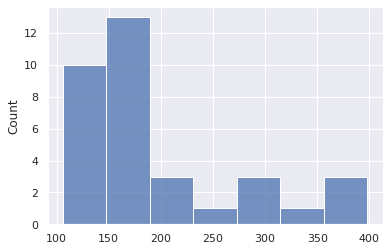

In [42]:
sns.histplot([len(track) for track in rfp_tracks if len(track) >100])

In [23]:
[(track.ID, len(track)) for track in rfp_tracks if len(track) >100]

[(6, 225),
 (12, 381),
 (138, 106),
 (144, 292),
 (355, 262),
 (428, 112),
 (432, 185),
 (453, 160),
 (467, 159),
 (590, 184),
 (622, 189),
 (626, 203),
 (632, 295),
 (636, 398),
 (642, 366),
 (646, 330),
 (657, 111),
 (752, 227),
 (806, 174),
 (817, 146),
 (818, 148),
 (828, 312),
 (832, 131),
 (834, 131),
 (928, 119),
 (1238, 156),
 (1444, 155),
 (1453, 174),
 (1937, 150),
 (1918, 173),
 (1940, 149),
 (1943, 146),
 (1968, 116),
 (1967, 116)]

In [24]:
track_806 = [track for track in rfp_tracks if track.ID == 806][0]

In [32]:
tracks = [track for track in rfp_tracks if track.ID == 806 
             or track.ID == 590 
             or track.ID == 355]

In [36]:
track_590 = [track for track in rfp_tracks if track.ID == 590][0]

<AxesSubplot:>

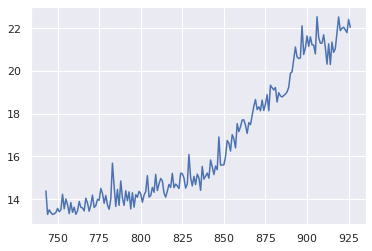

In [43]:
sns.lineplot(x = track_590['t'], y = track_590['mean_intensity'])

Text(0.5, 1.0, 'Concatenated RFP intensity profile of extruding cell')

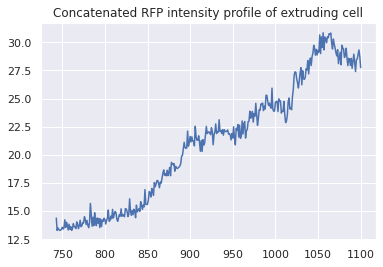

In [60]:
sns.lineplot(x = track_590['t']+track_806['t'], y = list(track_590['mean_intensity'])+list(track_806['mean_intensity']))
plt.title('Concatenated RFP intensity profile of extruding cell')

Text(0.5, 1.0, 'RFP intensity profile of non-extruding cell')

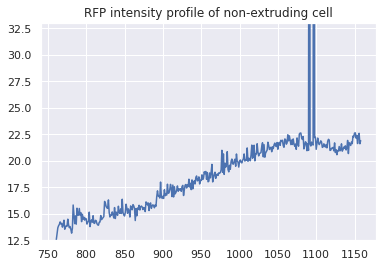

In [62]:
track_636 = [track for track in rfp_tracks if track.ID == 636][0]
sns.lineplot(x = track_636['t'], y = track_636['mean_intensity'])
plt.ylim(12.5, 33)
plt.title('RFP intensity profile of non-extruding cell')

# Finessing tracking

First checking out some tracks

In [84]:
[track for track in gfp_tracks if track.ID == 1273][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,prob_apoptosis,eccentricity,prob_metaphase,class id,mean_intensity,prob_interphase,prob_prometaphase,prob_anaphase,area
0,1273,501,596.084412,1060.171631,0.0,1273,1273,3,0,False,1.448156e-18,0.815677,8.054890e-14,1.0,54.456039,1.153838e-21,6.458173e-27,1.000000e+00,339.0
1,1273,502,599.904358,1061.738037,0.0,1273,1273,3,0,False,1.363504e-16,0.844939,1.824591e-12,1.0,59.380825,4.040588e-20,4.619252e-27,1.000000e+00,297.0
2,1273,503,594.681946,1061.945557,0.0,1273,1273,3,0,False,2.573181e-18,0.848020,1.763380e-11,1.0,53.861641,4.507019e-19,1.135371e-25,1.000000e+00,348.0
3,1273,504,593.393982,1061.912109,0.0,1273,1273,3,0,False,1.642485e-14,0.763614,9.837374e-10,1.0,45.115128,1.985092e-15,4.029596e-21,1.000000e+00,476.0
4,1273,505,591.233154,1058.558105,0.0,1273,1273,3,0,False,1.687030e-13,0.771355,8.817093e-09,1.0,42.577503,6.845217e-14,4.625441e-20,1.000000e+00,523.0
5,1273,506,589.524963,1057.679199,0.0,1273,1273,3,0,False,1.890791e-11,0.760240,2.713306e-03,1.0,40.495213,1.046595e-07,7.623882e-12,9.972866e-01,571.0
6,1273,507,587.727539,1056.521240,0.0,1273,1273,3,0,False,7.491327e-08,0.732805,2.061228e-02,1.0,39.774300,2.290649e-03,2.962765e-10,9.770969e-01,576.0
7,1273,508,586.870178,1056.290894,0.0,1273,1273,3,0,False,3.400456e-07,0.685135,1.317949e-03,1.0,38.812843,1.240737e-01,2.088542e-10,8.746082e-01,578.0
8,1273,509,587.000610,1055.282104,0.0,1273,1273,0,0,False,2.385349e-06,0.633225,3.869086e-05,1.0,38.343212,7.384382e-01,1.854729e-11,2.615208e-01,597.0
9,1273,510,587.212097,1054.352051,0.0,1273,1273,0,0,False,6.396490e-07,0.634247,1.628203e-05,1.0,38.689625,9.848463e-01,6.954121e-12,1.513666e-02,614.0


In [75]:
track = [track for track in gfp_tracks if track.ID == 2597][0]

In [77]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,prob_apoptosis,eccentricity,prob_metaphase,class id,mean_intensity,prob_interphase,prob_prometaphase,prob_anaphase,area
0,2597,701,574.764160,1071.127197,0.0,2597,2597,0,0,False,3.692526e-11,0.483706,6.131657e-15,1.0,35.382759,1.000000e+00,2.283681e-11,2.272204e-17,1215.0
1,2597,702,570.237244,1069.502441,0.0,2597,2597,0,0,False,6.678872e-10,0.474121,1.758926e-14,1.0,34.744141,1.000000e+00,1.046488e-10,1.444113e-17,1209.0
2,2597,703,565.803528,1069.737305,0.0,2597,2597,0,0,False,1.466038e-10,0.515474,8.781855e-15,1.0,34.741615,1.000000e+00,1.455559e-09,1.679630e-16,1205.0
3,2597,704,571.695435,1069.909302,0.0,2597,2597,0,0,False,4.258795e-11,0.495901,2.407503e-14,1.0,34.812759,1.000000e+00,1.581476e-11,3.218519e-17,1228.0
4,2597,705,572.662048,1069.485474,0.0,2597,2597,0,0,False,5.632624e-10,0.500397,9.671295e-13,1.0,35.262184,1.000000e+00,2.698340e-09,4.375283e-15,1258.0
5,2597,706,574.406189,1068.481689,0.0,2597,2597,0,0,False,1.061651e-09,0.526657,7.086381e-13,1.0,34.598431,1.000000e+00,3.630631e-10,4.642494e-15,1269.0
6,2597,707,570.211426,1068.002197,0.0,2597,2597,0,0,False,6.259396e-11,0.485137,7.466967e-14,1.0,35.878597,1.000000e+00,7.771146e-10,1.146632e-16,1270.0
7,2597,708,569.085205,1068.700562,0.0,2597,2597,0,0,False,9.118892e-11,0.496729,1.478470e-13,1.0,35.397907,1.000000e+00,8.560885e-11,9.387861e-16,1271.0
8,2597,709,569.033386,1067.905273,0.0,2597,2597,0,0,False,2.631667e-10,0.456532,5.429100e-13,1.0,35.577961,1.000000e+00,2.469259e-10,1.204203e-15,1278.0
9,2597,710,568.774475,1066.789673,0.0,2597,2597,0,0,False,7.697679e-10,0.514261,1.497091e-12,1.0,34.312004,1.000000e+00,1.560620e-09,2.961978e-15,1310.0


#### Length distribution of all tracks

(0.0, 200.0)

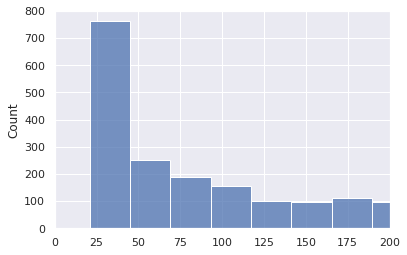

In [83]:
sns.histplot([len(track) for track in gfp_tracks if len(track) > 20])
plt.xlim(0, 200)

In [91]:
### how many tracks would I really expect?
N_cells_t750 = len([track for track in gfp_tracks if 750 in track.t])

240

In [93]:
from tqdm.auto import tqdm

In [99]:
N_cells = []
for t in tqdm(range(0,1265), total = 1265):
    N_cells.append(len([track for track in gfp_tracks if t in track.t]))

  0%|          | 0/1265 [00:00<?, ?it/s]

In [96]:
import numpy as np

In [101]:
len(N_cells)

1265

In [106]:
len(np.linspace(0,1265, 1265))

1265

Text(0.5, 1.0, 'Growth of wild-type cells over time')

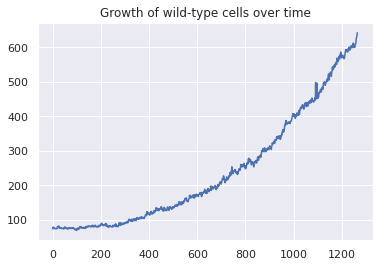

In [108]:
sns.lineplot(x = np.linspace(0,1265, 1265), y = N_cells)
plt.title('Growth of wild-type cells over time')

In [109]:
N_cells = []
for t in tqdm(range(0,1265), total = 1265):
    N_cells.append(len([track for track in rfp_tracks if t in track.t]))

  0%|          | 0/1265 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Growth of Ras cells over time')

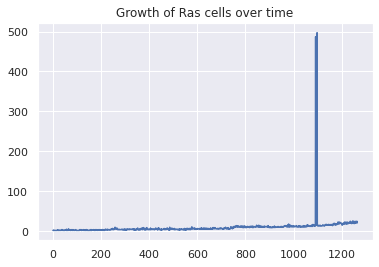

In [110]:
sns.lineplot(x = np.linspace(0,1265, 1265), y = N_cells)
plt.title('Growth of Ras cells over time')

(0.0, 50.0)

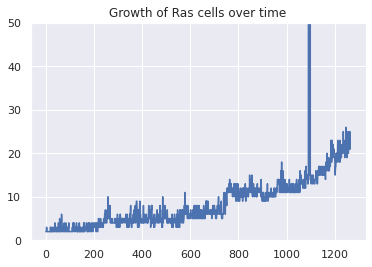

In [111]:
sns.lineplot(x = np.linspace(0,1265, 1265), y = N_cells)
plt.title('Growth of Ras cells over time')
plt.ylim(0,50)

In [113]:
len([track for track in rfp_tracks if 1097 in track.t])

497

In [119]:
[track for track in rfp_tracks if 1097 in track.t][-1]

,ID,t,x,y,z,parent,root,state,generation,dummy,prob_apoptosis,eccentricity,prob_metaphase,class id,mean_intensity,prob_interphase,prob_prometaphase,prob_anaphase,area
0,1617,1097,290.479553,1188.453491,0.0,1617,1617,0,0,False,"(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array","(1,) array"


In [117]:
len([track for track in rfp_tracks if track.t[-1] == 497])

1

# Manual identification: Load images in Napari

From experiment info, load each set of images and launch napari if experimental condition is met

In [ ]:
root_dir = '/home/nathan/data/kraken/ras/'

viewer = napari.Viewer()
ratio = '90:10'
induced = True
tracks = False
aligned = True
#expts = set(df['Experiments'])
expts = ['ND0013']

for expt in expts:
    expt_dir = os.path.join(root_dir, expt)
    if os.path.exists(expt_dir):
        positions = natsorted([pos for pos in os.listdir(expt_dir) if pos.startswith('Pos') and os.path.isdir(os.path.join(expt_dir, pos))])
        for pos in positions:

            ### load expt condition
            condition = df['Condition'].loc[(df['Experiments'] == expt) & (df['Positions'] == pos)].values[0]
            ### if i want only induced experiments
            if induced:
                ### skip uninduced expts
                if '-' in condition:
                    print(expt, pos, condition, 'uninduced, skipping to next expt.')
                    continue
            ### check condition for correct ratio and skip if not
            if ratio not in condition:
                print(expt, pos, condition, 'incorrect seeding ratio, skipping to next expt.')
                continue
            ### load images
            else:
                print('Loading', expt, pos, condition)
                ### define image path
                image_path = os.path.join(root_dir, expt, pos, f'{pos}_images')
                ### check if alignment is to be applied
                if aligned:
                    transform_path = os.path.join(root_dir, expt, pos, 'gfp_transform_tensor.npy')
                else:
                    transform_path = False
                ### load images
                images = DaskOctopusLiteLoader(image_path, 
                                               transforms = transform_path,
                                               crop = (1200,1600))
                ### launch the napari viewer
                #viewer = napari.Viewer()
                viewer.add_image(images['gfp'], colormap= 'green', name= 'gfp', 
                                 blending = 'additive', contrast_limits = [0,150])
                viewer.add_image(images['rfp'], colormap= 'red', name='rfp', 
                                 blending = 'additive', contrast_limits = [0,32])
                viewer.add_image(images['irfp'], colormap= 'blue', name='irfp', 
                                 blending = 'additive')
                viewer.add_labels(images['mask'], name = f'{expt, pos} masks')
            
                ### check if tracks are to be added too
                if tracks:
                    tracks_path = ''
                    with btrack.dataio.HDF5FileHandler(tracks_path, 'r',obj_type=obj_type) as h:
                        tracks = h.tracks
                    ### need to configure this
                    data, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)
                    tracker_layer = viewer.add_tracks(data, properties=properties,graph=graph,name='tracks_1')
#                 points_layer = ...
                viewer.show(block=True)


# checking transforms

In [14]:
root_dir = '/home/nathan/data/kraken/ras/'

viewer = napari.Viewer()
ratio = '90:10'
induced = True
tracks = False
aligned = True
#expts = set(df['Experiments'])
expts = ['ND0013']
 & (df['Condition'] == "90:10 wt:ras+" )
for expt in expts:
    expt_dir = os.path.join(root_dir, expt)
    if os.path.exists(expt_dir):
        
        positions = natsorted([pos for pos in os.listdir(expt_dir) if pos.startswith('Pos') and os.path.isdir(os.path.join(expt_dir, pos))])
        for pos in positions:

            ### load expt condition
            condition = df['Condition'].loc[(df['Experiments'] == expt) & (df['Positions'] == pos)].values[0]
            ### if i want only induced experiments
            if induced:
                ### skip uninduced expts
                if '-' in condition:
                    print(expt, pos, condition, 'uninduced, skipping to next expt.')
                    continue
            ### check condition for correct ratio and skip if not
            if ratio not in condition:
                print(expt, pos, condition, 'incorrect seeding ratio, skipping to next expt.')
                continue
            ### load images
            else:
                print('Loading', expt, pos, condition)
                ### define image path
                image_path = os.path.join(root_dir, expt, pos, f'{pos}_images')
                ### check if alignment is to be applied
                if aligned:
                    transform_path = os.path.join(root_dir, expt, pos, 'gfp_transform_tensor.npy')
                else:
                    transform_path = False
                ### load images
                images = DaskOctopusLiteLoader(image_path, 
                                               transforms = transform_path,
                                               crop = (1200,1600))
                ### launch the napari viewer
                #viewer = napari.Viewer()
                viewer.add_image(images['gfp'], colormap= 'green', name= 'gfp', 
                                 blending = 'additive', contrast_limits = [0,150])
                viewer.add_image(images['rfp'], colormap= 'red', name='rfp', 
                                 blending = 'additive', contrast_limits = [0,32])
                viewer.add_image(images['irfp'], colormap= 'blue', name='irfp', 
                                 blending = 'additive')
                viewer.add_labels(images['mask'], name = f'{expt, pos} masks')
            
                ### check if tracks are to be added too
                if tracks:
                    tracks_path = ''
                    with btrack.dataio.HDF5FileHandler(tracks_path, 'r',obj_type=obj_type) as h:
                        tracks = h.tracks
                    ### need to configure this
                    data, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)
                    tracker_layer = viewer.add_tracks(data, properties=properties,graph=graph,name='tracks_1')
#                 points_layer = ...
                viewer.show(block=True)


dask.array<astype, shape=(2788, 1200, 1600), dtype=uint8, chunksize=(1, 1200, 1600), chunktype=numpy.ndarray>

# Extrusion information extraction function
(on pause as I realised I need full track info for focal extrusion)

In [42]:
### load json file with events
event_dict_fn = '/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/extrusions/extrusions.json'
with open(event_dict_fn, 'r') as file:
    event_dict = json.load(file)
    
### 

event_dict.append(event_ID)

{}

In [ ]:
@viewer.bind_key('w')
def note_event(event=None):
    if tracks:
        cell_ID = tracker_layer._get_value()
        position = tracker_layer.coordinates 
    else:
        ch = 'RFP'
        position = 
        cell_ID = 'na'
        points_layer.data = np.append(points_layer.data,cell_positions,axis=0)
    event_ID = f'{expt}_{pos}_{cell_ID}_{ch}':f'{int(position[0])}\n'
    with open(txt_address,'a') as txt_file:
        txt_file.write(txt_entry)
    txt_file.close()
    selected_track_lengths.append(len(cell_track.t))
    latest_added_track.append('r')
    

# @viewer.bind_key('w')
# def erase_latest_entry(event=None):
#     global selected_track_lengths 
#     global latest_added_track
#     with open(txt_address,'r+') as txt_file:
#         lines = txt_file.readlines()
#         txt_file.seek(0)
#         for line in lines[:-1]:
#             txt_file.write(line)
#         txt_file.truncate()
#     txt_file.close()
#     if latest_added_track[-1] == 's':
#         stitched_points_layer.data = stitched_points_layer.data[:-selected_track_lengths[-1]]
#     elif latest_added_track[-1] == 'r':
#         points_layer.data = points_layer.data[:-selected_track_lengths[-1]]
#     selected_track_lengths = selected_track_lengths[:-1]
#     latest_added_track = latest_added_track[:-1]
